# Analysis for the kinematics 
> _If you cannot see the HTML rendering (e.g. colors), view this notebook [here](https://nbviewer.jupyter.org/github/Mipanox/ME303/blob/master/kinematics/kinematics.ipynb)_

* The videos were taken by Lentink lab's Phantom LC310 and Sony RX10 III high-speed cameras.
* Video digitization was done by the MATLAB DigitizingTools developed by the [Hedrick Lab](http://www.unc.edu/~thedrick/software1.html) at UNC 

In [31]:
from IPython.display import YouTubeVideo

In [38]:
YouTubeVideo('17UyzKxHqd0', start=15, width=720, height=480)

In [39]:
YouTubeVideo('QmqNPAOs32A', width=720, height=480)

---

In [1]:
## prep
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

## <font color="blue">Examine the Video Frames</font>
Check the convention of indexing in `imageio` and the tracking points `csv` files.

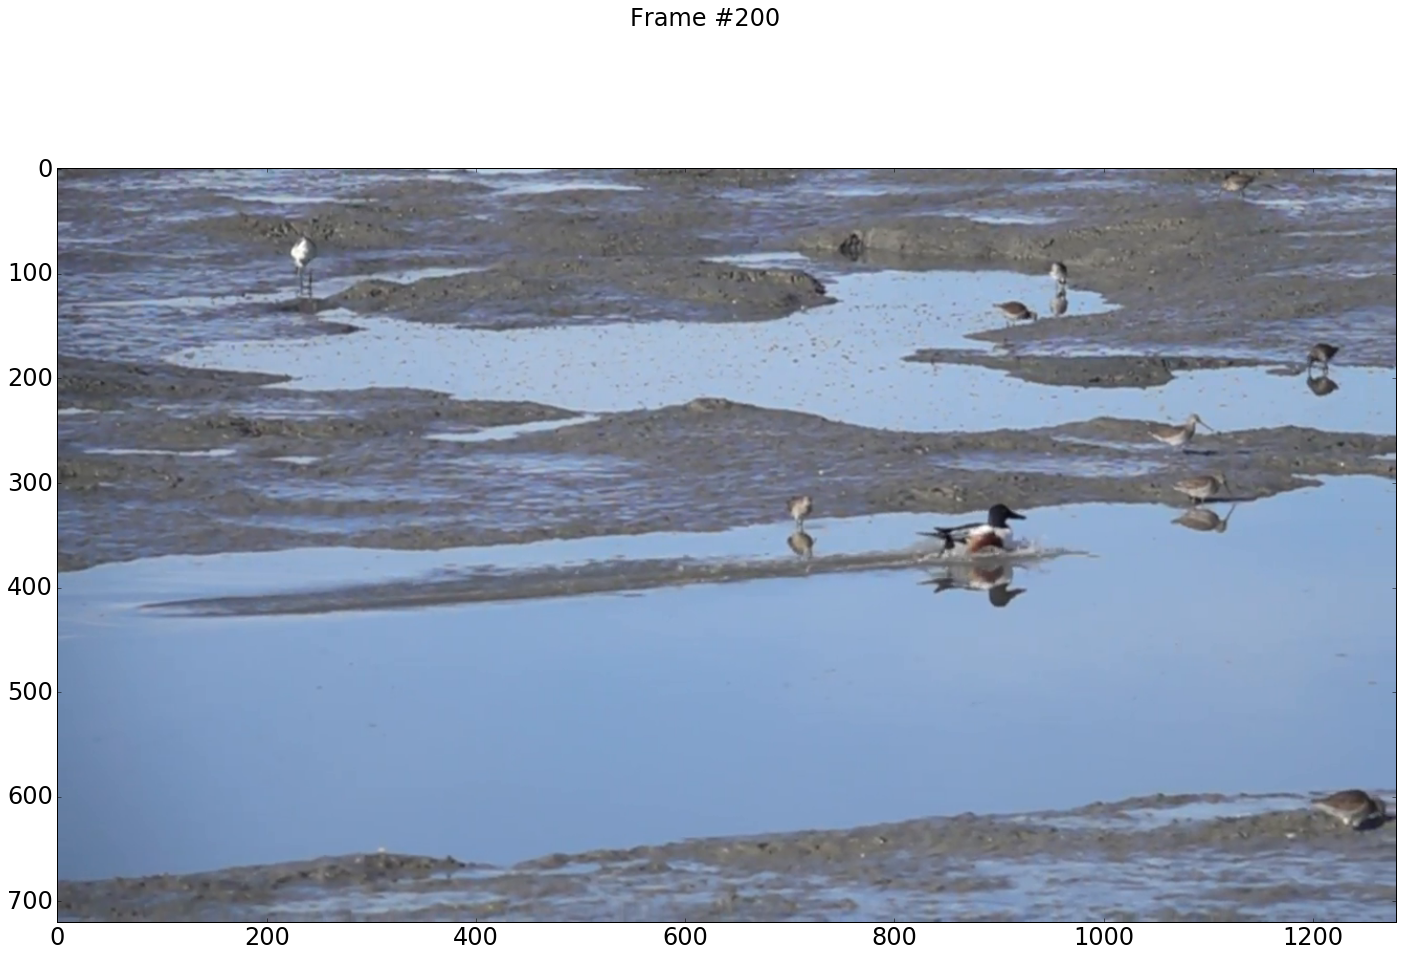

In [2]:
## The #200 frame in the trimmed and cropped avocet video
file_avo = './videos/avocet.mp4'
file_sho = './videos/shoveler.mp4'

vid_sho  = imageio.get_reader(file_sho,  'ffmpeg')
vid_avo  = imageio.get_reader(file_avo,  'ffmpeg')
nums = [10, 20, 100,200,400]

num = 200 # frame number
image = vid_sho.get_data(num)
fig, ax = plt.subplots(figsize=(24,16))
fig.suptitle('Frame #{}'.format(num), fontsize=24)
plt.xticks(fontsize=24); plt.yticks(fontsize=24)
plt.imshow(image)

In [3]:
## digitized points data
trk_avo = pd.read_csv('./tracking/avocet_xypts.csv')
trk_sho = pd.read_csv('./tracking/gliding_xypts.csv')

In [4]:
trk_sho.head(111)[101:]

pt1_cam1_X  pt1_cam1_Y  pt2_cam1_X  pt2_cam1_Y  pt3_cam1_X  pt3_cam1_Y  \
101  501.615670  266.714640      592.97      275.88  575.413985  233.915389   
102  504.690600  265.689664      599.04      277.82  581.563845  234.940366   
103  507.765529  263.639711      604.97      279.33  585.663752  238.015295   
104  516.990319  260.564781      610.98      280.59  588.738681  239.040272   
105  521.090225  262.614734      616.87      282.60  592.838588  241.090225   
106  528.265062  262.614734      622.60      284.15  603.088354  243.140179   
107  532.364968  265.689664      628.39      285.46  604.113330  246.215108   
108  538.514828  268.764594      633.84      286.45  610.263190  247.240085   
109  543.639711  271.839524      639.20      287.81  615.810000  248.920000   
110  551.839524  274.914453      644.76      289.81  621.480000  250.580000   

     pt4_cam1_X  pt4_cam1_Y  pt5_cam1_X  pt5_cam1_Y  pt6_cam1_X  pt6_cam1_Y  \
101  576.438962  258.514828  521.270000  244.980000  500.770000  264.360000   
102  581.563845  259.539804  526.060000  245.790000  503.665623  267.739617   
103  585.663752  260.564781  531.290000  246.950000  513.915389  272.864500   
104  591.813611  262.614734  537.320000  247.420000  522.115202  273.889477   
105  598.988447  265.689664  542.800000  247.950000  539.539804  279.014360   
106  605.138307  265.689664  547.250000  250.310000  548.764594  283.114266   
107  610.263190  269.789570  554.914453  247.240085  556.964407  285.164219   
108  616.413050  269.789570  560.039336  249.290038  563.114266  285.164219   
109  621.537933  270.814547  565.164219  251.339991  567.214173  287.214173   
110  628.712769  272.864500  571.314079  253.389945  571.870000  288.410000   

     pt7_cam1_X  pt7_cam1_Y  
101      586.12      393.40  
102      586.65      394.62  
103      587.12      396.37  
104      587.56      397.42  
105      588.03      398.46  
106      586.90      399.58  
107      586.58      401.31  
108      586.35      402.30  
109      587.55      403.96  
110      588.05      405.23

Looks like the indexing systems are opposite in the y direction...
<br>
Let's correct for that:

In [5]:
## dimensions; the 3rd dimension represents RGB colors
print vid_avo.get_data(0).shape
print vid_sho.get_data(0).shape

(720, 1280, 3)
(720, 1280, 3)


In [6]:
## "flip" the y axis
sho_y_max = vid_sho.get_data(0).shape[0]
avo_y_max = vid_avo.get_data(0).shape[0]

for column in range(trk_sho.shape[1]):
    if column%2:
        trk_sho.iloc[:,column] = sho_y_max - trk_sho.iloc[:,column]
for column in range(trk_avo.shape[1]):
    if column%2:
        trk_avo.iloc[:,column] = avo_y_max - trk_avo.iloc[:,column]   

---
## <font color="blue">Definitions</font>
Some information for calibration

### <font color="green">Projection</font>
*(Body length / wing span reference: Sibley's Field Guide)*
<br><br>
Overall, assume **no projection in the vertical direction**. Namely we are viewing the birds on the same horizontal.
<br><br>
To calibrate length scales, a nearby bird with known body length serves as a reference, as long as it lies in parallel to the x-axis. I may or may not take into account the motion angle projection in the analysis below.
<br><br>
<p style="text-indent: 10px"><font color="brown">Avocet</font>
    ![](./imgs/avo_proj_len_300x200.png)
<p style="text-indent: 30px"> motion angle $\approx 45^\circ$; 1 pixel $\approx$ 0.5 cm

<p style="text-indent: 10px"><font color="brown">Shoveler</font>
![](./imgs/sho_proj_len_1200x300.png)
<p style="text-indent: 30px"> motion angle $\approx 30^\circ$; 1 pixel $\approx$ 0.8 cm
<br><br>
As explained in the [models](https://github.com/Mipanox/ME303/blob/master/dynamics/models.ipynb) and [estimates](https://github.com/Mipanox/ME303/blob/master/others/estimates.ipynb) notebooks, I will not explore anything related to body rotations. Since projection does not affect the displacment/velocity in the y direction, it is not corrected. As for estimating x-direction kinematics, let's say $\cos30^\circ\approx0.87\sim1$.

### <font color="green">Frame Rate</font>
* <p style="text-indent: 10px"><font color="brown">Avocet</font>: 
  <p style="text-indent: 30px">Frame rate = 500 fps (original) / 30 fps in slow motion => **1 frame = 1/500 s** 
* <p style="text-indent: 10px"><font color="brown">Shoveler</font>:
  <p style="text-indent: 30px">Frame rate = 480 fps (original) / 30 fps in slow motion => **1 frame = 1/240 s**
  <p style="text-indent: 30px">*(note: here I assume half of the frames were lost since there are only 480 frames in total instead of the expected 960 frames for 2 seconds)*

---
## <font color="blue">Definitions and Approximations</font>

### <font color="green">Point Numbering</font>
|       |      Avocet      |   Shoveler       | color       |  (comments) |
|-------|------------------|------------------|-------------|-------------|
|    1  |   Right Wingtip  |   Right Wingtip  | <font color="red">red</font> |       -     |
|    2  |   Eye (right)    |   Beak tip       | <font color="blue">blue</font> |       -     |
|    3  |   Foot Toes      |   Foot Toes      | <font color="green">green</font> |       -     |
|    4  |   Neck base      |   Neck base      | <font color="brown">brown</font>/<font color="yellow">yellow</font> | nearest to the torso; the "body" |
|    5  |   Tail base      |   Tail tip       | <font color="cyan">cyan</font> |       -     |
|    6  |   Left Wingtip   |   Left Wingtip   | <font color="magenta">purple</font> |       -     |
|    7  |      -           |   Reference      | white | measures the motion of the camera |
<br><br>
![](./imgs/shoveler_pts.png)

### <font color="green">Assumptions</font>
* <p style="text-indent: 10px"><font color="brown">Wing</font>: 
  <p style="text-indent: 30px"> For simplicity, I'll first approximate each wing as a sinusoidally oscillating rod 
  (i.e. no morphing). 
  <p style="text-indent: 30px"> The amplitude is determined fully by the y-direction motion, and so on.
  
* <p style="text-indent: 10px"><font color="brown">Torso Rotation</font>: 
  <p style="text-indent: 30px"> The straight line connecting Point #4 and #5 (neck to tail bases) determines the rotation angle of the body.
  <p style="text-indent: 30px"> Rotations are assumed to be moving about the center of gravity. 
  <p style="text-indent: 30px"> For example, the avocets exhibit primarily 'pitch' rotation, therefore utilizing $I_\text{pitch}$ in dynamics.

---
### <font color="red">Codes</font>

In [7]:
exec(open('../codes/kine_util.py').read())

---
## <font color="blue">Results</font>

In [8]:
## no projection/coordinate transformations yet
bird = Kinematics(vid_sho=vid_sho,vid_avo=vid_avo,avo_proj=45,sho_proj=30, \
                  avo_pixl=0.5,sho_pixl=0.8,avo_fras=1./500,sho_fras=1./240, \
                  avo_data=trk_avo,sho_data=trk_sho,cutoff=4)

### <font color="green">Tracking...</font>

Avocet

In [ ]:
#bird.disp_traj(option=1)

In [ ]:
#import os
os.system('mkdir Avo_traj')
bird.traj_png(option=1)

Shoveler

In [ ]:
#bird.disp_traj(option=2)

In [ ]:
#import os
os.system('mkdir Sho_traj')
bird.traj_png(option=2)

### <font color="green">Kinematics: </font>
NOTE: Showing the results for "no coordinate transformations and projections" (yet)

Take a look at the position/velocity/acceleration/rotation...

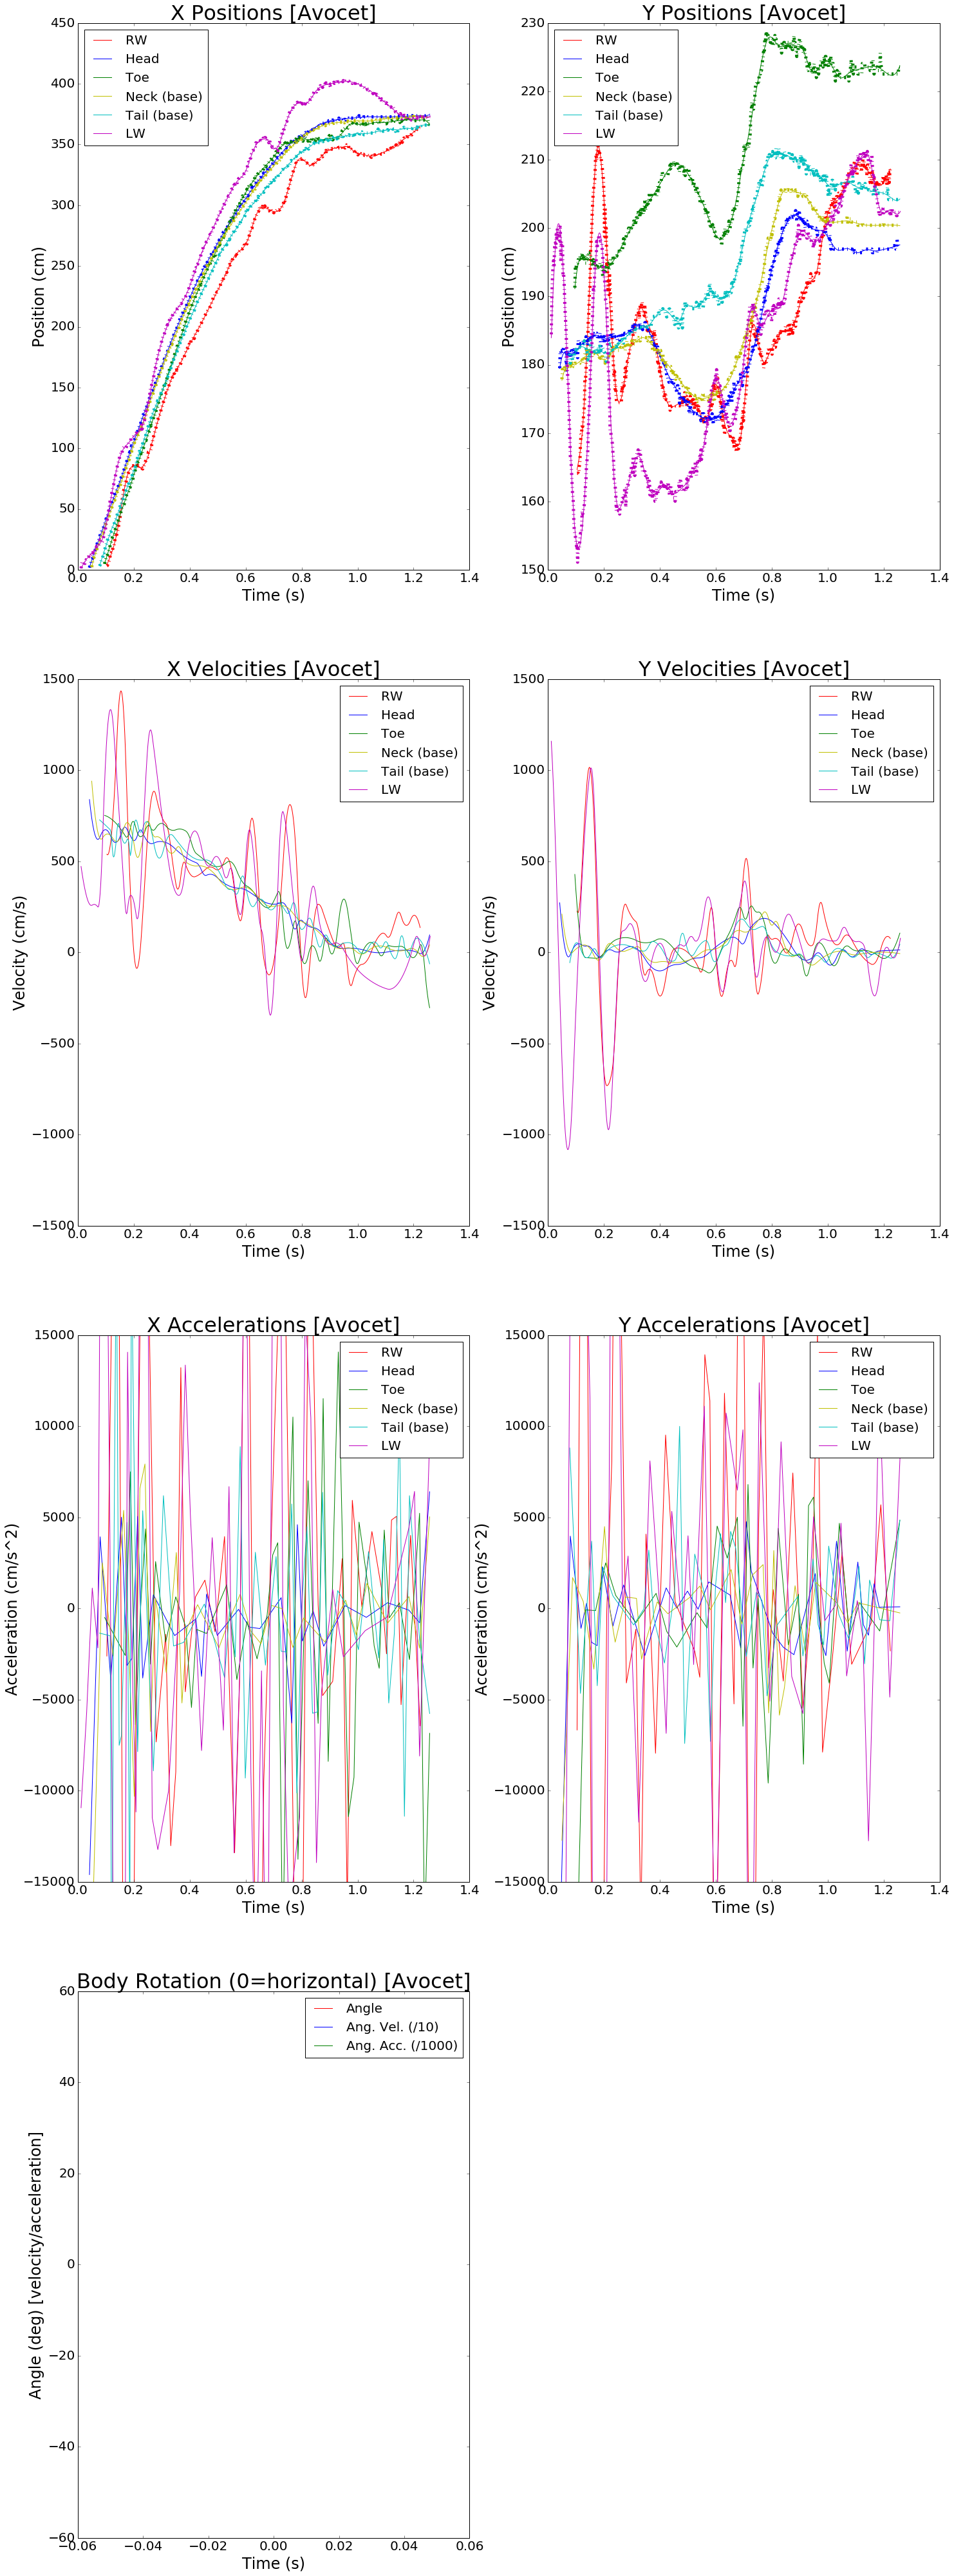

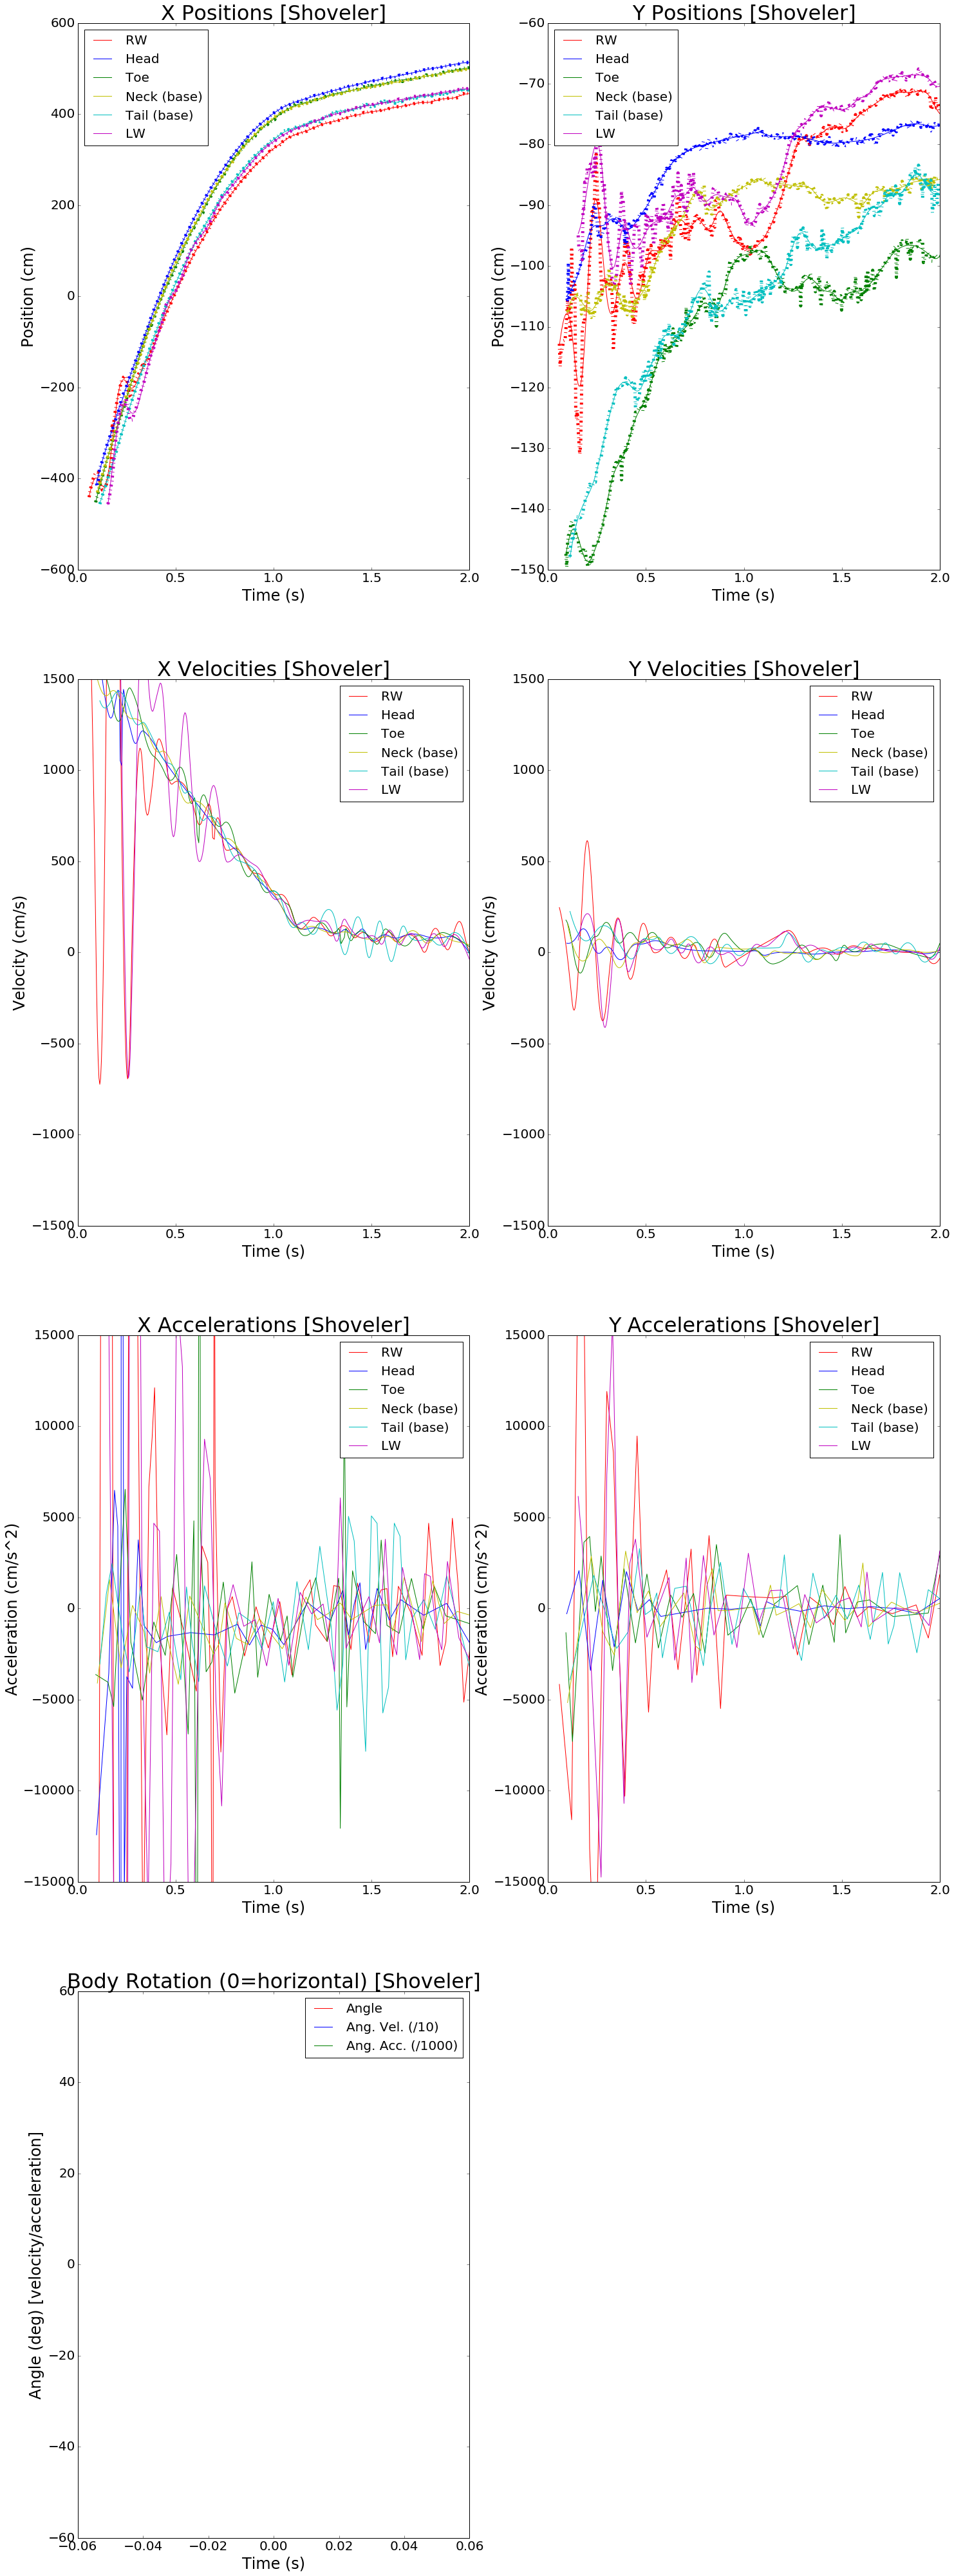

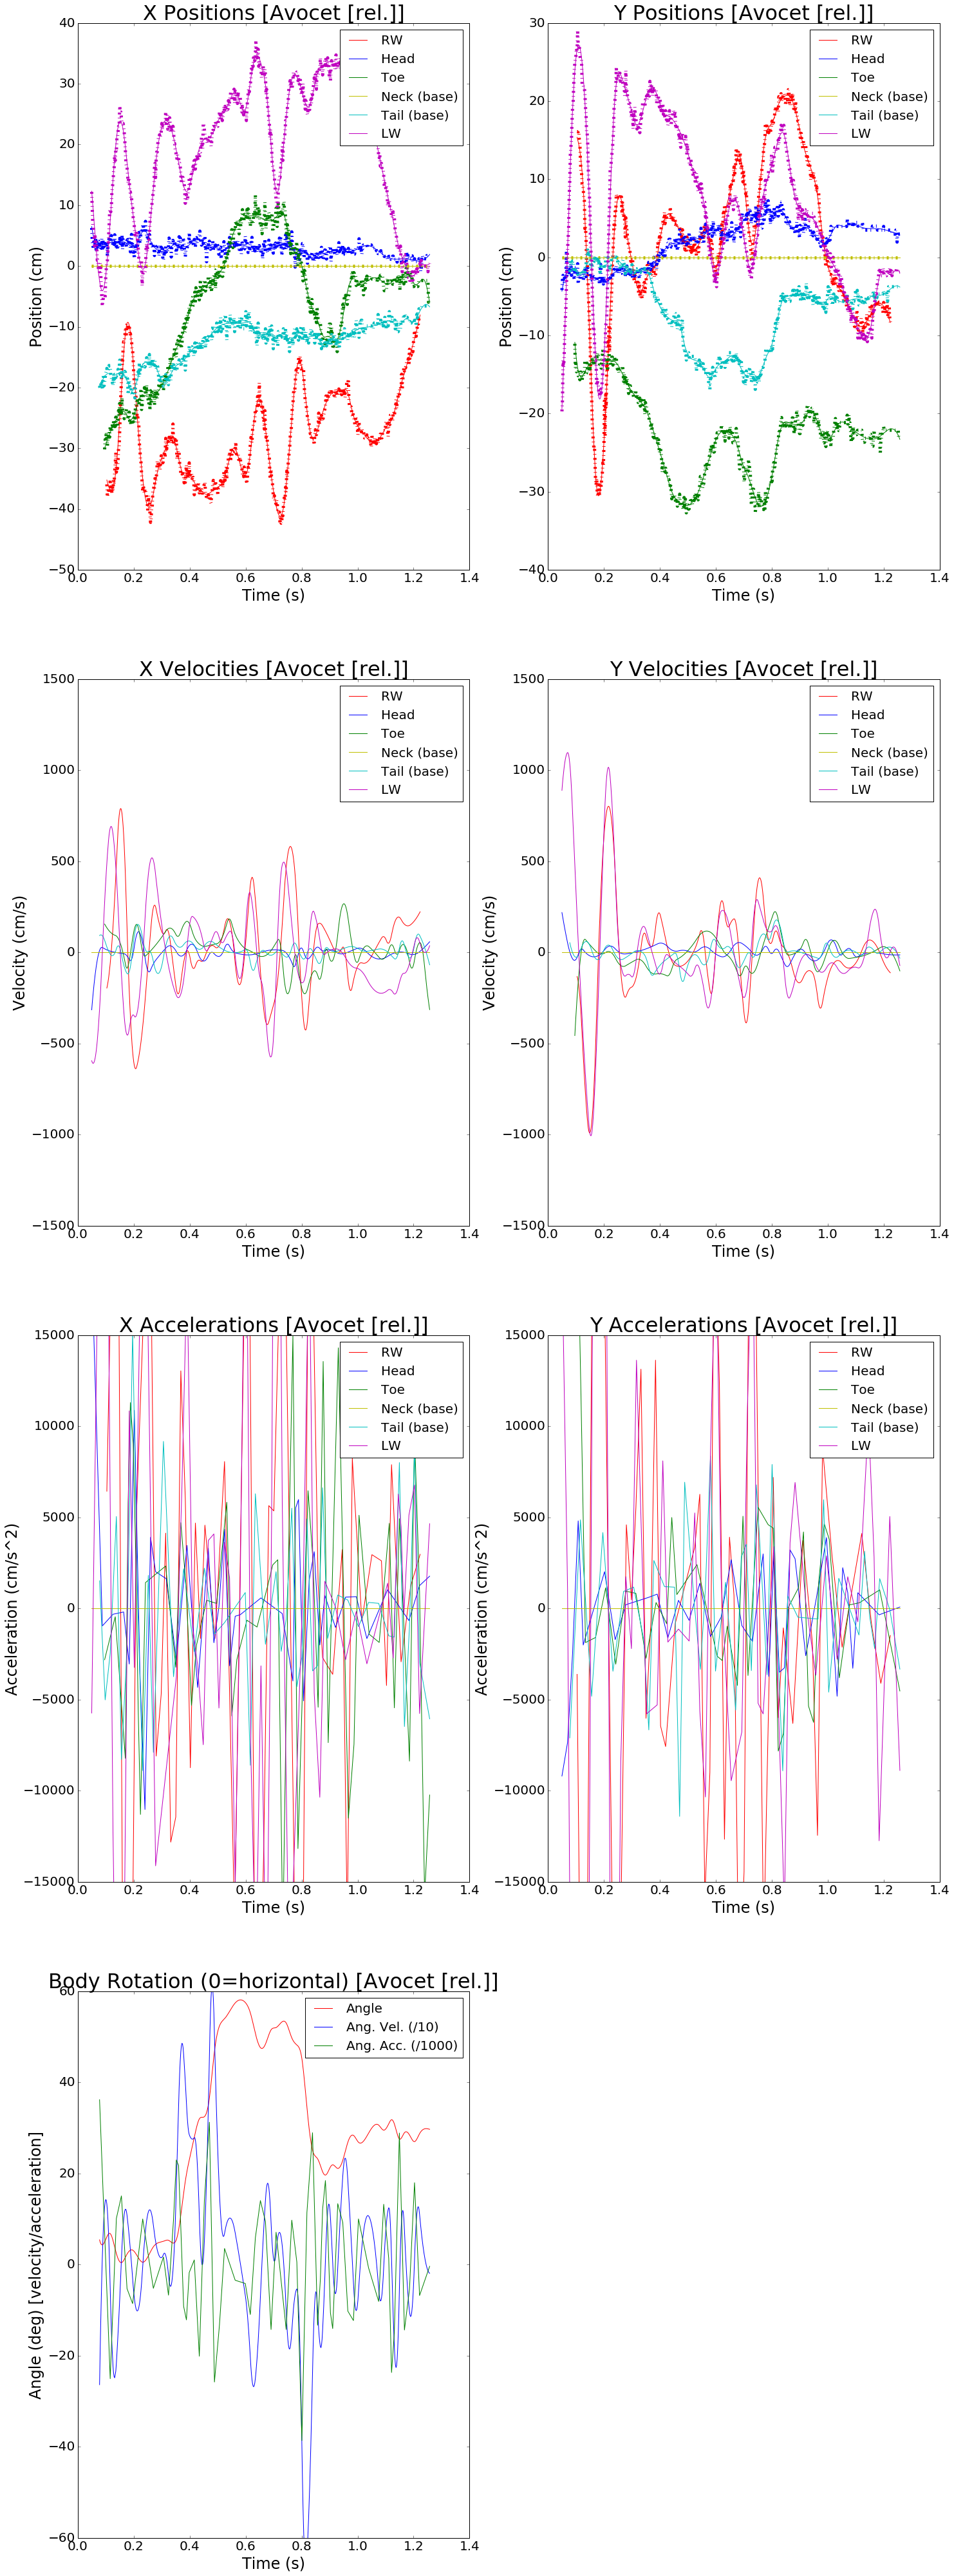

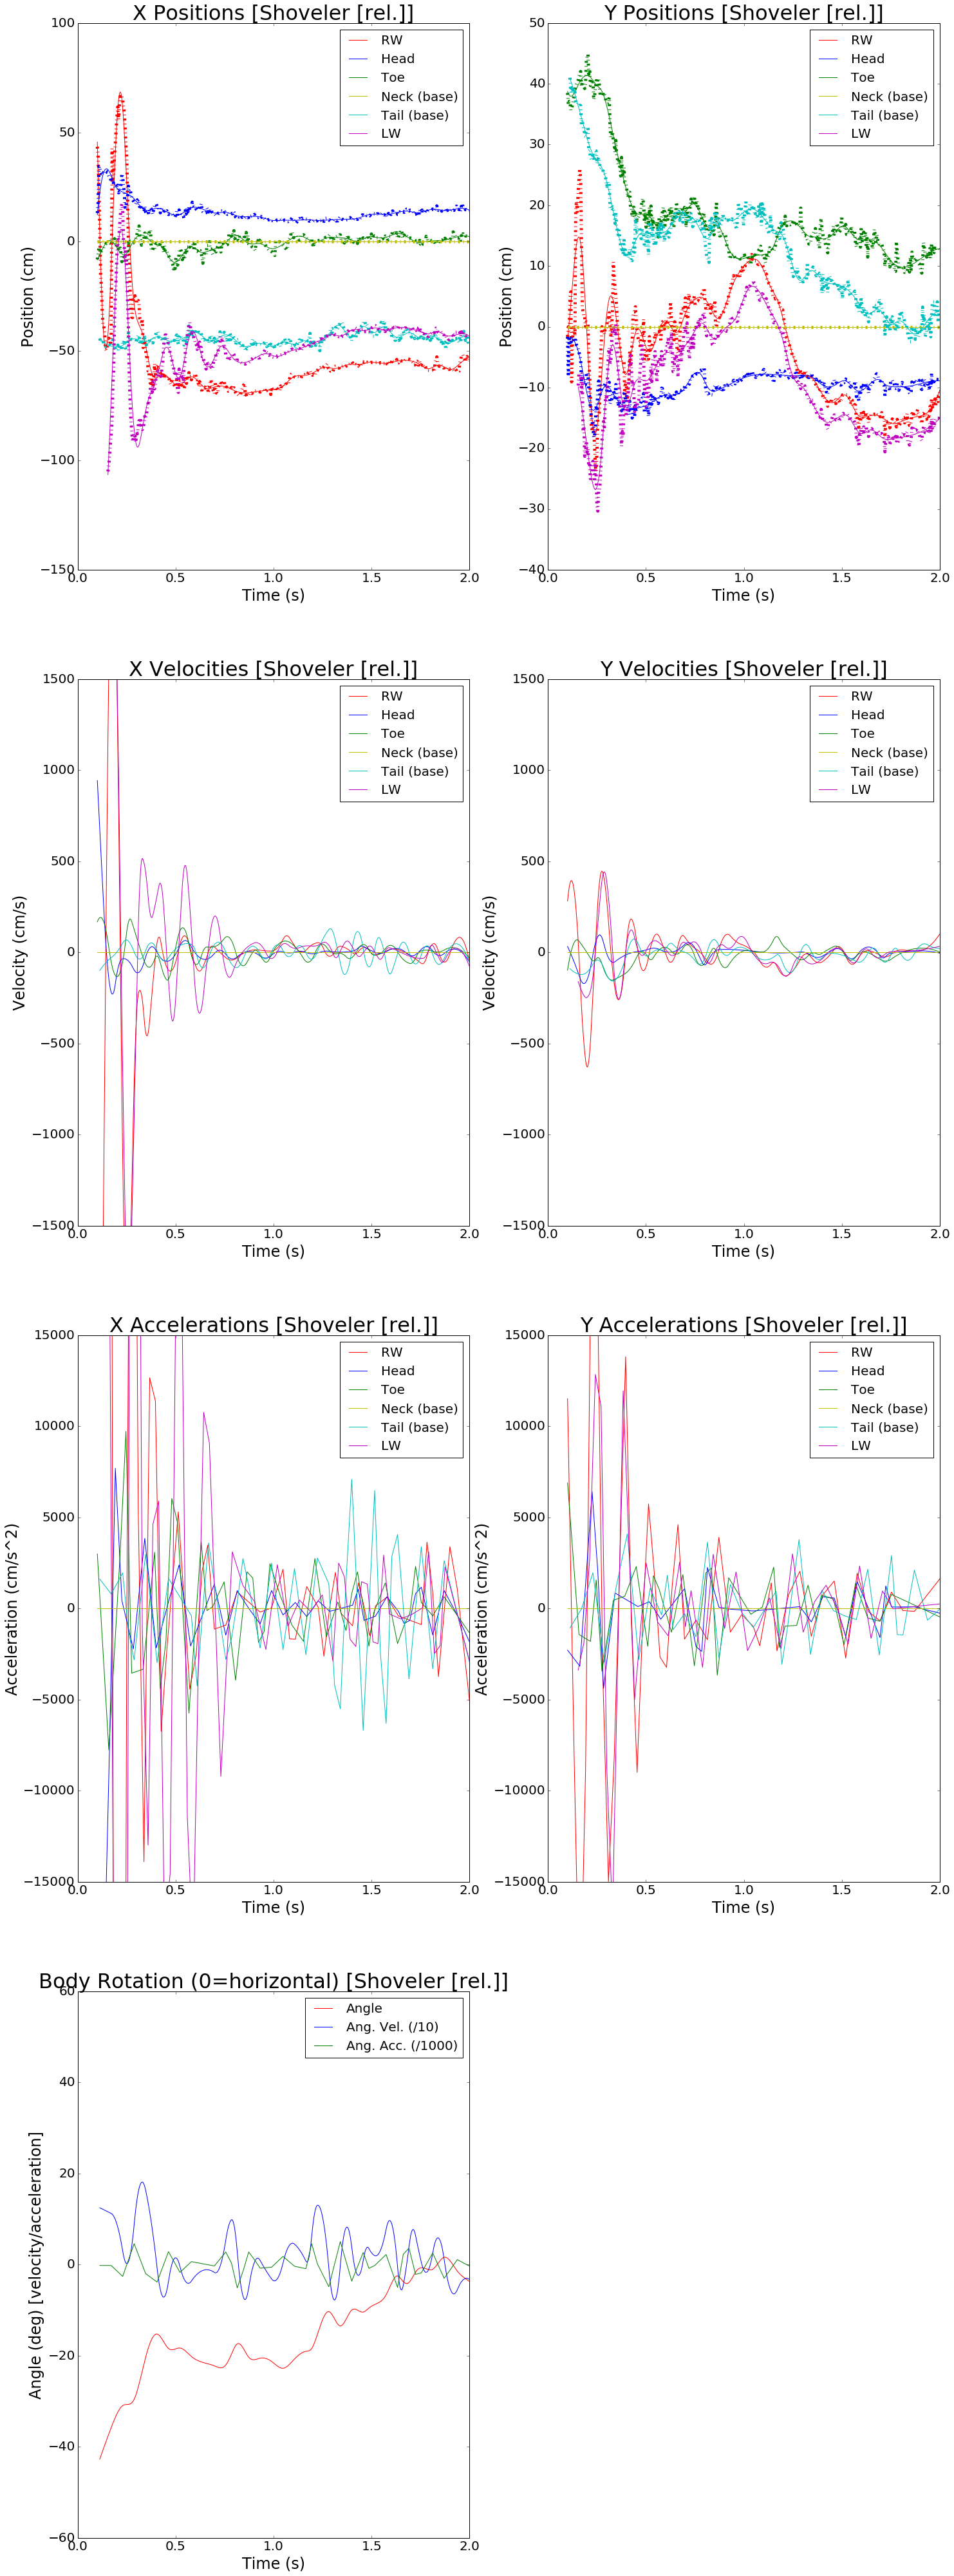

In [9]:
bird.disp_vel_acc()

Adding low-pass filter with cutoff at 4 x flapping frequency did not help much, but the magnitudes seem reasonable: 
Assume sinusoidal and flapping frequency $f=5$Hz and measure amplitude $A\approx20$cm, the acceleration will be $a\sim\omega^2A=(2\pi f)^2A\approx20000$(cm/s$^2$).
<br><br>
Note that the flapping frequencies are quite consistent, validating the conversion between frames and physical time elaspe.

---
### <font color="red">Save Data for later usage</font>

In [21]:
avo_tpva, sho_tpva, avo_cpva, sho_cpva = bird.vel_acc()
## Avocet
avt,avx,avy,avpx,avpy,avvx,avvy,avax,avay,avro = avo_cpva
av_ro_t,av_ro_p,av_ro_v,av_ro_a = avro

## Shoveler
sht,shx,shy,shpx,shpy,shvx,shvy,shax,shay,shro = sho_cpva
sh_ro_t,sh_ro_p,sh_ro_v,sh_ro_a = shro

In [22]:
col=['t','px','py','vx','vy','ax','ay']
avo_rw_df,sho_rw_df = pd.DataFrame(columns=col),pd.DataFrame(columns=col)
avo_hd_df,sho_hd_df = pd.DataFrame(columns=col),pd.DataFrame(columns=col)
avo_to_df,sho_to_df = pd.DataFrame(columns=col),pd.DataFrame(columns=col)
avo_ta_df,sho_ta_df = pd.DataFrame(columns=col),pd.DataFrame(columns=col)
avo_lw_df,sho_lw_df = pd.DataFrame(columns=col),pd.DataFrame(columns=col)

avo_ne_df = pd.DataFrame(columns=col)
sho_ne_df = pd.DataFrame(columns=col)

avo_ro_df = pd.DataFrame(columns=col)
sho_ro_df = pd.DataFrame(columns=col)

###
avo_df = [avo_rw_df,avo_hd_df,avo_to_df,avo_ne_df,avo_ta_df,avo_lw_df,avo_ro_df]
avo_ss = ['avo_rw_df','avo_hd_df','avo_to_df','avo_ne_df','avo_ta_df','avo_lw_df','avo_ro_df']
sho_df = [sho_rw_df,sho_hd_df,sho_to_df,sho_ne_df,sho_ta_df,sho_lw_df,sho_ro_df]
sho_ss = ['sho_rw_df','sho_hd_df','sho_to_df','sho_ne_df','sho_ta_df','sho_lw_df','sho_ro_df']

In [23]:
## Avocet
for (i,df) in enumerate(avo_df):
    if i==3 or i==6:
        ## neck (body) and rotation
        continue
    df['t']  = avt[i]
    df['px'],df['py'] = avpx[i],avpy[i]
    df['vx'],df['vy'] = avvx[i],avvy[i]
    df['ax'],df['ay'] = avax[i],avay[i]
##
avo_ne_df['t'] = avo_tpva[0][3]
avo_ne_df['px'],avo_ne_df['py'] = avo_tpva[3][3],avo_tpva[4][3]
avo_ne_df['vx'],avo_ne_df['vy'] = avo_tpva[5][3],avo_tpva[6][3]
avo_ne_df['ax'],avo_ne_df['ay'] = avo_tpva[7][3],avo_tpva[8][3]

##
avo_ro_df['t'] = av_ro_t
avo_ro_df['px'] = av_ro_p
avo_ro_df['vx'] = av_ro_v
avo_ro_df['ax'] = av_ro_a

In [24]:
for (i,df) in enumerate(avo_df):
    df.to_csv('./tpva_data/%s.csv' %avo_ss[i])

In [29]:
## Shoveler
for (i,df) in enumerate(sho_df):
    if i==3 or i==6:
        continue
    df['t']  = sht[i]
    df['px'],df['py'] = shpx[i],shpy[i]
    df['vx'],df['vy'] = shvx[i],shvy[i]
    df['ax'],df['ay'] = shax[i],shay[i]
##
sho_ne_df['t'] = sho_tpva[0][3]
sho_ne_df['px'],sho_ne_df['py'] = sho_tpva[3][3],sho_tpva[4][3]
sho_ne_df['vx'],sho_ne_df['vy'] = sho_tpva[5][3],sho_tpva[6][3]
sho_ne_df['ax'],sho_ne_df['ay'] = sho_tpva[7][3],sho_tpva[8][3]

##
sho_ro_df['t'] = sh_ro_t
sho_ro_df['px'] = sh_ro_p
sho_ro_df['vx'] = sh_ro_v
sho_ro_df['ax'] = sh_ro_a

In [30]:
for (i,df) in enumerate(sho_df):
    df.to_csv('./tpva_data/%s.csv' %sho_ss[i])